In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Ray optics and graded-index fibers ##

Fermat's principle, that light travels the least optical path, is equivalent to the principle of least action.  Let us consider media with refractive indices, $n$, which are $z$-independent (for example in a long fiber which extends infinitely along the $z$ axis).  The equations of motion follow from a Lagrangian $L=n(x,y)\sqrt{1+\dot{x}^2+\dot{y}^2}$ with overdot being $d/dz$ and $z$ taking the role of time.  Writing $\vec{q}=(x,y)$ for the transverse coordinates
$$
  \frac{d^2\vec{q}}{dz^2} = \frac{k^2}{2}\frac{\partial n^2}{\partial\vec{q}}
$$
where $k$ is a constant and I've written $\vec{\nabla}_q n^2$ as $\partial n^2/\partial\vec{q}$.

(In fact the connection between "ray optics" and Hamiltonian mechanics goes much deeper than this, both historically and physically.  See handouts.)

To begin with we will specialize even further to azimuthally symmetric systems where $n(x,y)=n(r)$ with $r=\sqrt{x^2+y^2}$ the polar length perpendicular to the optical axis, $z$.  Switching to cylindrical coordinates, $(r,\phi,z)$, and going to the Hamiltonian formulation so we obtain $1^{\rm st}$ order equations we have:
$$
  \dot{r}    = -\frac{p_r}{H} \quad , \quad
  \dot{\phi} = -\frac{p_\phi}{Hr^2}
$$
and
$$
  \dot{p}_r  = -\frac{1}{2H}\partial_r\left( n^2-p_\phi^2 r^{-2}\right)
$$
with $H=-\sqrt{n^2(r)-p_r^2-p_\phi^2/r^2}<0$ and $p_\phi$ constants of the motion.

For definiteness let us consider a refractive index $n^2=e-\exp[r]$ (not for any particular reason, but you could imagine this being motivated by [Graded Index Fibers](https://en.wikipedia.org/wiki/Graded-index_fiber)).  We now have three $1^{\rm st}$ order differential equations to evolve.  We have several choices for integrator, here I'll just use the SciPy ```solve_ivp``` routine:

Text(0, 0.5, 'Energy')

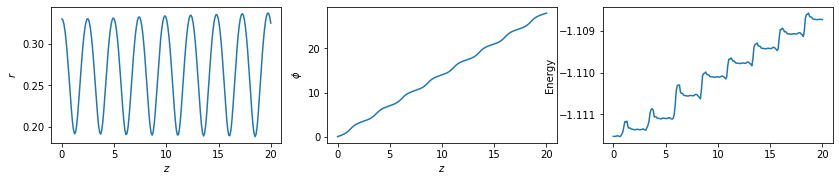

In [2]:
from scipy.integrate import solve_ivp

# Define our n^2 and its derivative just to make the code
# below clearer and easier to modify.
def nsqr(rr):
    return( np.exp(1)-np.exp(rr) )
def dnsqr(rr):
    return( -np.exp(rr) )

def derivs(t,y):
    """The derivatives for the ODE integration."""
    # Order our variables as [r,phi,p_r] and return the derivatives in this order.
    # Just to make bookkeeping easier we'll pass p_phi as the last argument as well,
    # and return a zero derivative for it.
    rr    =  y[0].clip(1e-3,1)
    p_r   =  y[2]
    pphi  =  y[3]
    H     = -np.sqrt(nsqr(rr)-p_r**2-pphi**2/rr**2)
    dy    =  np.zeros_like(y)
    dy[0] = -p_r/H
    dy[1] = -pphi/H/rr**2
    dy[2] = -0.5/H*(dnsqr(rr)+2*pphi**2/rr**3)
    dy[3] =  0.0
    return(dy)
    #
zobs = np.linspace(0.,20.,200)
y0   = np.array([0.33,0.0,0.0,0.1])
res  = solve_ivp(derivs,[zobs[0],zobs[-1]],y0,t_eval=zobs)
res  = res.y
# Compute the energy function vs. time as well.  This
# should be exactly conserved if our numerics are perfect.
rr   = res[0,:]
phi  = res[1,:]
p_r  = res[2,:]
pphi = res[3,:]
H    =-np.sqrt(nsqr(rr)-p_r**2-pphi**2/rr**2)
# and make a series of plots
fig,ax = plt.subplots(1,3,figsize=(14,2.5))
ax[0].plot(zobs,rr)
ax[1].plot(zobs,phi)
ax[2].plot(zobs,H)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$r$')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\phi$')
ax[2].set_ylabel(r'Energy')

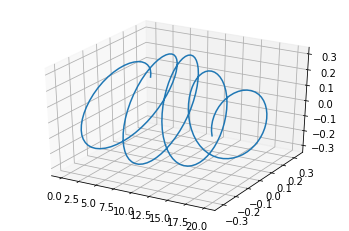

In [3]:
# Let's look at our trajectory in 3D!
from mpl_toolkits.mplot3d import Axes3D
#
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# If we observe along x then our fiber is running more left-right
# which makes the trajectory slightly easier to see.
ax.plot(rr*np.cos(phi),rr*np.sin(phi),zobs,zdir='x')

You can play with the initial conditions, and with the "potential" (i.e. $n^2$) to get different behaviors.  See if you can find some interesting orbits!

### Symplectic integrators ###

Note that our energy is pretty well conserved, because this is a relatively simple set of equations to solve.  For dynamical systems where we're integrating Hamilton's or Lagrange's equations there are methods which take advantage of the special form of such equations to produce much more accurate solutions than "typical" ODE integrators.  The theory of such integrators is also quite interesting and has cool links with physics (though it's more widely applicable).  To learn more about this, look up `symplectic integrators`.

## Maxwell's fish-eye lens ##

[Maxwell's fish-eye lens](https://en.wikipedia.org/wiki/Luneburg_lens#Maxwell's_fish-eye_lens) is a sphere of radius $R$ with a refractive
index varying with radius as
$$
  n=\frac {n_0}{1+[r/R]^2}
$$
and being independent of the angular coordinates.  The paths of the rays are arcs of circles inside the lens and the lens focuses each point on the spherical surface to the opposite point on the same surface.

While the particular case Maxwell introduced allows for an analytic solution (and the case $n(r)\propto r^{-2}$ is even easier) let us study this numerically. 

Since the lens exhibits spherical symmetry, the motion of the light ray
will be in a plane so we can just consider the plane and use polar coordinates.
Since $n$ is a function only of $r$, it seems to make sense to take $\theta$ as our
"time" coordinates so that $L$ is $t$-independent and $H$ is conserved.
Then we would have
$$
  L = n\sqrt{r^2 + \dot{r}^2}
  \quad\Rightarrow\quad
  H =  \frac{n(r)\dot{r}^2}{\sqrt{r^2+\dot{r}^2}} - n(r)\sqrt{r^2+\dot{r}^2}
    = -\frac{n(r)r^2}{\sqrt{r^2+\dot{r}^2}}
    = {\rm const} = E
$$
with an overdot being $d/d\theta$.  An alternative approach is to take $r$ as our "time coordinate", and look at $\theta(r)$ then note that the Lagrangian is $\theta$-independent and so $p_\theta$ is conserved.  This second approach is very slightly easier for an analytic solution but the former is a little easier to deal with numerically.

While the special "Maxwell form" of $n(r)$ leads to an analytic solution in terms of quadratures, let's instead play with our equations in Hamiltonian form numerically.  With $\theta$ as our "time coordinate" we have
$$
  p_r = \frac{\delta L}{\delta\dot{r}} = \frac{n(r)\,\dot{r}}{\sqrt{r^2+\dot{r}^2}}
  \quad\Rightarrow\quad
  \dot{r} = \frac{rp_r}{\sqrt{n^2-p_r^2}}
  \quad\Rightarrow\quad
  \sqrt{r^2+\dot{r}^2} = \frac{n(r)\,r}{\sqrt{n^2-p_r^2}}
$$
and our Hamiltonian is
$$
  H = -\frac{n(r)\,r^2}{\sqrt{r^2+\dot{r}^2}}
    = -r\sqrt{n^2-p_r^2}
$$
leading to Hamilton equations
$$
  \dot{r} = \frac{\delta H}{\delta p_r}
          = \frac{r\,p_r}{\sqrt{n^2-p_r^2}}
  \quad\mathrm{and}\quad
  \dot{p_r} = -\frac{\delta H}{\delta r}
            = \sqrt{n^2-p_r^2} + \frac{r\,nn'}{\sqrt{n^2-p_r^2}}
$$

If we want to allow the ray to keep going when it hits the other side of the lens, we could imagine putting a mirror around the sphere.  This would have the effect of changing the sign of $dr/\theta$ at the point of reflection.

Text(0, 0.5, '$p_r$')

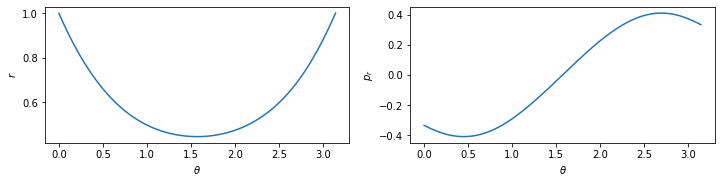

In [4]:
# Define our n(r) and its derivative just to make the code
# below clearer and easier to modify.
def nn(rr):
    return( 1.0/(1.0 + rr**2) )
def dn(rr):
    return( -2*rr/(1+rr**2)**2 )

def derivs(t,y):
    """The derivatives for the ODE integration."""
    # Order our variables as [r,pr] and return the derivatives in this order.
    dy    = np.zeros_like(y)
    rr    = y[0].clip(1e-4,1)
    pr    = y[1]
    rt    = np.sqrt(nn(rr)**2 - pr**2)
    dy[0] = rr*pr/rt
    dy[1] = rt + rr*nn(rr)*dn(rr)/rt
    return(dy)
    #
# We'll start out ray at theta=0, r=1 and pr<0.  To keep
# sqrt[n^2-pr^2] positive we need |pr|<0.5.  Larger |pr|
# gives paths with larger radius of curvature.
# Obviously rotational invariance means we can start at any
# theta we want, but 0 seems convenient.
tobs = np.linspace(0.,np.pi,200)
y0   = np.array([1.0,-0.3333])
res  = solve_ivp(derivs,[tobs[0],tobs[-1]],y0,t_eval=tobs)
res  = res.y
# and make a plot of the ray position.  Could do this as a
# polar plot, but could also just do ...
fig,ax = plt.subplots(1,2,figsize=(12,2.5))
ax[0].plot(tobs,res[0,:])
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$r$')
ax[1].plot(tobs,res[1,:])
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$p_r$')

Text(0, 0.5, '$y$')

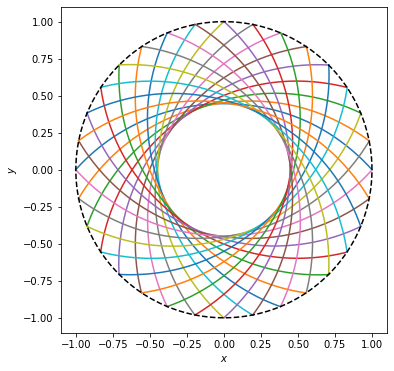

In [5]:
# Plot the ray position.  We'll actually plot multiple arcs,
# using the fact that we can just offset tobs in order to
# change starting positions!
# Could do this as a polar plot, but could also just do ...
fig,ax = plt.subplots(1,1,figsize=(6,6))
for i in range(32):
    # Plot multiple rays, starting from different angles
    dt = i * 2*np.pi/32
    ax.plot(res[0,:]*np.cos(tobs+dt),res[0,:]*np.sin(tobs+dt))
# Now put a dashed black line for the lens outer boundary.
tt = np.linspace(0,2*np.pi,500)
ax.plot(np.cos(tt),np.sin(tt),'k--')
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')